
Python was not able to load the fast fortran material routines.


*************************************************************
Loading gmsh-mesh from H:\TUM-PC\Dokumente\Projects\AMfe\meshes/test_meshes/simple_2.msh
Mesh H:\TUM-PC\Dokumente\Projects\AMfe\meshes/test_meshes/simple_2.msh successfully imported. 
Assign a material to a physical group.
*************************************************************


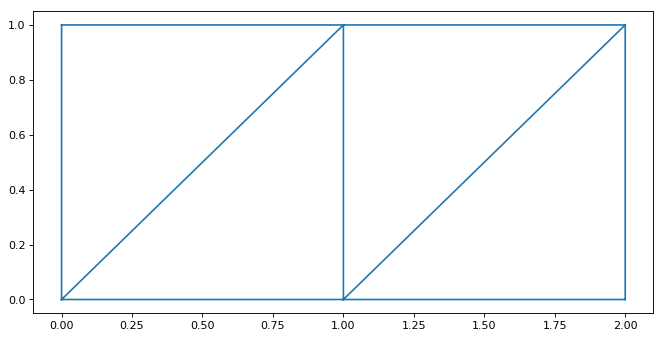

In [1]:
# importing lib and setting a list of meshes to be tested
import sys 
import amfe
import matplotlib.pyplot as plt
import numpy as np
import scipy
import copy
import pandas as pd

msh_dict = {}
msh_dict[0] = amfe.amfe_dir('meshes/test_meshes/Geom3.msh')
msh_dict[1] = amfe.amfe_dir('meshes/test_meshes/simple_2.msh')
msh_dict[2] = mshfile = amfe.amfe_dir('meshes/test_meshes/3_partition_pressure_corner.msh')
msh_dict[3] = mshfile = amfe.amfe_dir('meshes/test_meshes/geo_hole_quad_part_4.msh')
msh_dict[4] = mshfile = amfe.amfe_dir('meshes/test_meshes/2_partitions_quad_mesh.msh')
msh_dict[5] = mshfile = amfe.amfe_dir('meshes/test_meshes/2_partitions_2quad_mesh.msh')
msh_dict[6] = mshfile = amfe.amfe_dir('meshes/test_meshes/4_partitions_quad_mesh.msh')
msh_dict[7] = mshfile = amfe.amfe_dir('meshes/test_meshes/3_partition_2d_blade_quad_mesh.msh')
msh_dict[8] = mshfile = amfe.amfe_dir('meshes/test_meshes/1_quad_elem.msh')


domain_id = {}
domain_id[0] = 3
domain_id[1] = 3
domain_id[2] = 11
domain_id[3] = 8
domain_id[4] = 3
domain_id[5] = 3
domain_id[6] = 3
domain_id[7] = 3
domain_id[8] = 6


# select mesh to be plotted
mesh_id1 = 1
mshfile = msh_dict[mesh_id1]

m1 = amfe.Mesh()
m1.import_msh(mshfile)

domain = m1.set_domain('phys_group', domain_id[mesh_id1])

fig, ax1=plt.subplots(1,figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
amfe.plot_submesh(domain,ax1)
plt.show()

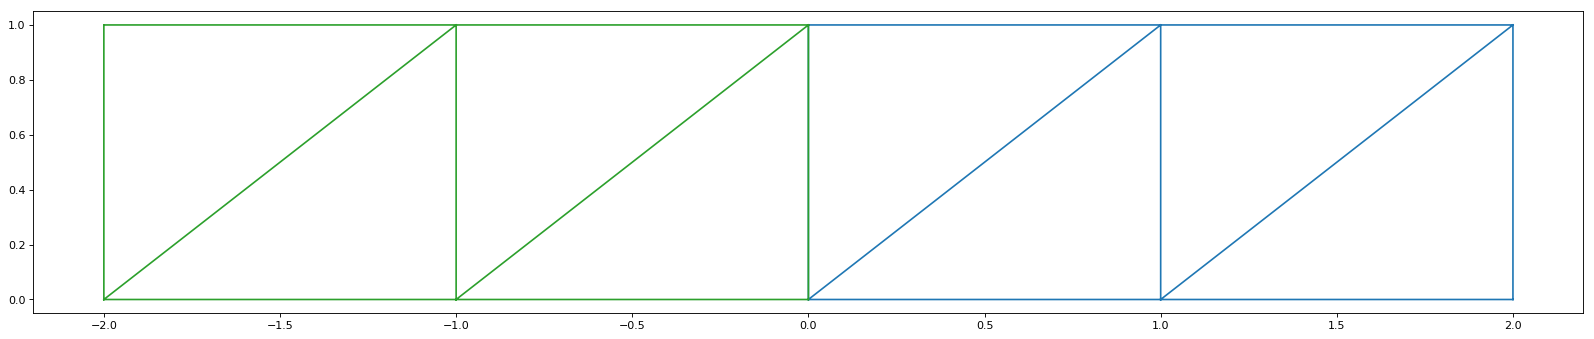

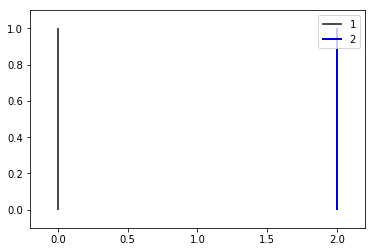

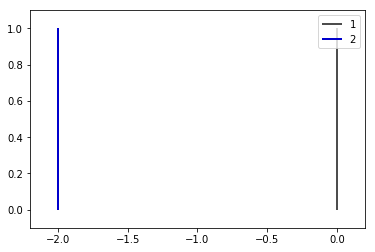

In [2]:
# applying tranlation to mesh

sys.path.append(r"H:\TUM-PC\Dokumente\Projects\FETI")
from cyclic_domain_test import *

key  = 1
x_offset = 0.0
y_offset = 0.0
z_offset = 0.0
vector_offset = [x_offset,y_offset,z_offset]
new = translation(m1.nodes,vector_offset)


# creating submesh 1
submesh1 = copy.deepcopy(m1.groups[domain_id[mesh_id1]])
submesh1.parent_mesh.nodes = new
submesh1 = m1.groups[domain_id[mesh_id1]]
submesh1.parent_mesh.nodes = new

# creating submesh 2
submesh2 = copy.deepcopy(submesh1)
new = rot_z(submesh2.parent_mesh.nodes,180,ref_point_vector=[0,0.5,0])
submesh2.parent_mesh.nodes = new

fig, ax1=plt.subplots(1,figsize=(25, 5), dpi= 80, facecolor='w', edgecolor='k')
amfe.plot_submesh(submesh1,ax1)
amfe.plot_submesh(submesh2,ax1)



amfe.plot_boundary_1d(submesh1.parent_mesh)
amfe.plot_boundary_1d(submesh2.parent_mesh)
plt.show()

In [3]:
# creating material
my_material = amfe.KirchhoffMaterial(E=210E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=0.1)

# append domains to MechanicalAssembly
my_system = amfe.MechanicalAssembly()
my_system.append_domain(submesh1, my_material,1)
my_system.append_domain(submesh2, my_material, 2)


my_system.update_global_system()

In [4]:
# selectiong submeshes for boundary condition
# select submesh for Neumann B.C
sub_neu1 = my_system.get_submesh(1,2)



# select submesh for Dirichlet
sub_dir1 = my_system.get_submesh(2,2)

# select submesh for interfaces
sub_int1 = my_system.get_submesh(1,1)
sub_int2 = my_system.get_submesh(2,1)



# appling bc
value = 10e8
my_system.apply_neumann_boundaries(sub_neu1,value)
my_system.apply_dirichlet_boundaries(sub_dir1,0.0,'xy')

my_system.add_bonded_interface_constraint(sub_int1,sub_int2)


# replacing phys tags to avoid conflict

my_system.change_domain_physical_tag(2,1,4)
my_system.change_domain_physical_tag(2,2,5)
my_system.update_global_system()
my_system.el_df

,idx_gmsh,local_idx,el_type,no_of_tags,phys_group,geom_entity,no_of_mesh_partitions,partition_id,partitions_neighbors,domain,5,6,7
0,1,1,straight_line,4,1,1,1,1,None,1,0,5,NaN
1,2,2,straight_line,4,2,3,1,1,None,1,2,3,NaN
2,3,3,Tri3,5,3,1,2,1,"[-2, -3]",1,0,1,4.0
3,4,4,Tri3,5,3,1,2,1,"[-2, -3]",1,0,4,5.0
4,5,5,Tri3,5,3,1,2,2,[-1],1,1,2,3.0
5,6,6,Tri3,5,3,1,2,2,[-1],1,1,3,4.0
6,7,1,straight_line,4,4,1,1,3,None,2,5,0,NaN
7,8,2,straight_line,4,5,3,1,3,None,2,8,9,NaN
8,9,3,Tri3,5,3,1,2,3,"[-4, -1]",2,5,7,10.0
9,10,4,Tri3,5,3,1,2,3,"[-4, -1]",2,5,10,0.0


In [5]:

new_mesh = my_system.get_global_mesh()
# creating material
my_material = amfe.KirchhoffMaterial(E=210E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=0.1)

value = 1e8
my_comp = amfe.MechanicalSystem()
my_comp.set_mesh_obj(new_mesh)
my_comp.set_domain(3,my_material)
my_comp.apply_dirichlet_boundaries(5, 'xy')
my_comp.apply_neumann_boundaries(2, value, 'normal')

s = amfe.LinearStaticsSolver(my_comp)
s.solve()

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


def plot_static(scale=1):
    fig, ax1=plt.subplots(1,figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
    amfe.plot_system_solution(my_comp, factor=scale, ax = ax1)
    plt.show()
    
interact(plot_static,scale=(0,1000,5))  

*************************************************************

 phys_group 3 with 8 elements successfully added.
Total number of elements in mesh: 8
*************************************************************
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 8 elements and 20 dofs.
Time taken for preallocation: 0.00 seconds.

 phys_group 5 with 2 nodes successfully added to Dirichlet Boundaries.
Total number of nodes with Dirichlet BCs: 2
Total number of constrained dofs: 4
*************************************************************

 phys_group 2 with 1 elements successfully added to Neumann Boundary.
Total number of neumann elements in mesh: 1
Total number of elements in mesh: 8
*************************************************************
Attention: No linear solver was given, setting linear_solver = PardisoSolver.
Attention: No pseudo time evaluation was given, setting t = 1.0.
Assembling external force and stiffness...
Start solving linear static prob

C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\py36\Lib\site-packages\scipy\sparse\sputils.py:114: UserWarning: object dtype is not supported by sparse matrices
  warnings.warn("object dtype is not supported by sparse matrices")


A Jupyter Widget

<function __main__.plot_static>

Extract interface node from sub_1 and sub_2
Extract interface node from sub_1 and sub_3
Interface nodes from sub_2 and sub_1 already extracted
Interface nodes from sub_3 and sub_1 already extracted
Extract interface node from sub_3 and sub_4
Interface nodes from sub_4 and sub_3 already extracted
Extract interface node from sub_1 and sub_2
Extract interface node from sub_1 and sub_3
Interface nodes from sub_2 and sub_1 already extracted
Interface nodes from sub_3 and sub_1 already extracted
Extract interface node from sub_3 and sub_4
Interface nodes from sub_4 and sub_3 already extracted


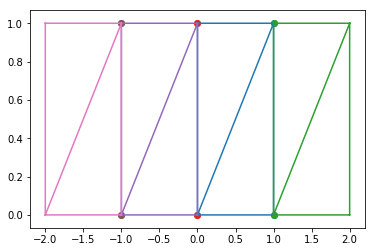

In [6]:
domain = my_system.update_domain()
my_system.split_in_partitions()
domain = my_system
my_system.groups

amfe.plot_domain(my_system)
plt.show()

In [7]:
g1 = my_system.groups[1]
g2 = my_system.groups[2]
g3 = my_system.groups[3]
g4 = my_system.groups[4]


In [8]:
print(g1.interface_nodes_dict)
print(g2.interface_nodes_dict)
print(g3.interface_nodes_dict)
print(g4.interface_nodes_dict)

{2: [1, 4], 3: [0, 5]}
{1: [1, 4]}
{1: [0, 5], 4: [10, 7]}
{3: [10, 7]}


In [9]:
super_domain = amfe.SuperDomain(domain.groups)
B = super_domain.assemble_global_B()
Kd, fd = super_domain.assemble_block_stiffness_and_force()
G, e = super_domain.assemble_global_G_and_e()

BTGT = -B.T.dot(G.T)
GB = -G.dot(B)

n_dof = super_domain.total_displacement_dofs
n_int = super_domain.total_lambda_dofs
n_null = super_domain.total_alpha_dofs

block_zero_1 = np.zeros([n_null,n_int+n_null])
block_zero_2 = np.zeros([n_int,n_int+n_null])

zero_vector = np.zeros(n_int+n_null)

A1 = np.hstack((Kd,BTGT,B.T))
A2 = np.hstack((GB,block_zero_1))
A3 = np.hstack((B,block_zero_2))


A = np.vstack((A1,A2,A3))
b = np.concatenate((fd,zero_vector))

Ainv = np.linalg.pinv(A)
x = Ainv.dot(b)
x = np.linalg.solve(A,b)

x = np.linalg.solve(A,b)
u_dual = x[:n_dof]
alpha_dual = x[n_dof:n_dof+n_null]
lambda_dual = x[n_dof+n_null:]


u_dual = x[:n_dof]
alpha_dual = x[n_dof:n_dof+n_null]
lambda_dual = x[n_dof+n_null:]


print('u = ', u_dual)
print('lambda = ', lambda_dual)
print('alpha = ', alpha_dual)

u = super_domain.eval_subdomain_displacement(lambda_dual,alpha_dual)

print(u)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


def plot_static(scale=0):
    connectivity = {}
    nodes = {}
    ax = plt.axes()
    for sub_key in super_domain.domains_key_list:
        sub = super_domain.get_feti_subdomains(sub_key)
        connectivity[sub_key] = sub.mesh.connectivity
        nodes[sub_key] = sub.mesh.nodes
        quad, ax = amfe.plotDeformQuadMesh(connectivity[sub_key],nodes[sub_key],u[sub_key],scale,ax) 
          
    plt.show()

interact(plot_static,scale=(0,10,0.1))  

Preallocating the stiffness matrix
Done preallocating stiffness matrix with 2 elements and 8 dofs.
Time taken for preallocation: 0.00 seconds.
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 2 elements and 8 dofs.
Time taken for preallocation: 0.00 seconds.
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 2 elements and 8 dofs.
Time taken for preallocation: 0.00 seconds.
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 2 elements and 8 dofs.
Time taken for preallocation: 0.00 seconds.
u =  [ 0.09638848  0.0172244   0.14400871  0.02410629  0.13713064  0.00982107
  0.0895175   0.00295392  0.14400871  0.02410629  0.19162779  0.0309847
  0.1847495   0.01669902  0.13713064  0.00982107  0.0895175   0.00295392
  0.04207937 -0.00358275  0.04873305  0.01023642  0.09638848  0.0172244
  0.04207937 -0.00358275  0.          0.          0.          0.
  0.04873305  0.01023642]
lambda =  [ -1.95290497e+09   4.99020171e+

C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\py36\Lib\site-packages\scipy\sparse\compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


A Jupyter Widget

<function __main__.plot_static>

In [10]:
u_dual

array([ 0.09638848,  0.0172244 ,  0.14400871,  0.02410629,  0.13713064,
        0.00982107,  0.0895175 ,  0.00295392,  0.14400871,  0.02410629,
        0.19162779,  0.0309847 ,  0.1847495 ,  0.01669902,  0.13713064,
        0.00982107,  0.0895175 ,  0.00295392,  0.04207937, -0.00358275,
        0.04873305,  0.01023642,  0.09638848,  0.0172244 ,  0.04207937,
       -0.00358275,  0.        ,  0.        ,  0.        ,  0.        ,
        0.04873305,  0.01023642])

In [11]:
u

{1: array([  1.32519000e+09,   8.42722719e+08,   1.32519000e+09,
          7.32648526e+08,   1.43526420e+09,   7.32648525e+08,
          1.43526420e+09,   8.42722719e+08]),
 2: array([ -1.27714961e+08,   5.72285580e+09,  -1.27714961e+08,
          9.38539677e+09,  -3.79025593e+09,   9.38539677e+09,
         -3.79025593e+09,   5.72285580e+09]),
 3: array([  7.85696334e+08,  -4.11136650e+09,   7.85696334e+08,
         -4.52625086e+09,   1.20058069e+09,  -4.52625086e+09,
          1.20058069e+09,  -4.11136650e+09]),
 4: array([ -3.35640531e-01,   1.35334276e+00,   1.20342780e-16,
          4.90496152e-17,   0.00000000e+00,   0.00000000e+00,
          3.01887498e-01,   1.52575712e+00])}

In [12]:
B.dot(u_dual)

array([ -3.60822483e-16,  -2.77555756e-17,  -1.94289029e-16,
        -1.43982049e-16,  -2.49800181e-16,   3.81639165e-17,
        -9.71445147e-17,  -5.11743425e-17,   5.55111512e-17,
        -3.46944695e-18,   5.55111512e-17,  -4.77048956e-17])

In [13]:
GB.dot(u_dual)

array([ -3.41740525e-16,   1.66533454e-16,  -3.19189120e-16,
         1.70002901e-16,  -1.38777878e-17,   2.44596010e-16,
        -2.16840434e-17,   7.63278329e-17,  -2.38741318e-16])

In [14]:
fint = Kd.dot(u_dual) + BTGT.dot(alpha_dual) + B.T.dot(lambda_dual)

In [15]:
r = fint - fd

In [16]:
r.dot(r)

3.2182256859414338e-11

In [17]:
u_primal = my_comp.u_output[1]

u_dual = amfe.FetiSolver.average_displacement_calc(my_system, super_domain.feti_subdomains_dict)
plt.plot(u_primal,u_dual,'o')

AttributeError: 'Assembly' object has no attribute 'id_matrix'

In [ ]:
u_dual

In [ ]:
u_primal

In [ ]:
u_dual = x[:n_dof]

In [ ]:
u_dual

In [ ]:
x

In [ ]:
B = super_domain.assemble_global_B()
Kd, fd = super_domain.assemble_block_stiffness_and_force()
G, e = super_domain.assemble_global_G_and_e()
F, d = super_domain.assemble_F_and_d()

n_null = len(e) # null space size
n_int = len(d) # interface size
Zeros = np.zeros([n_null ,n_null])

A1 = np.hstack((F,G.T))
A2 = np.hstack((G,Zeros))

A = np.vstack((A1,A2))
b = np.concatenate((d,e))

# Dual interface problem
x = np.linalg.solve(A,b)
global_lambda = x[:n_int]
alpha = x[n_int:]

global_alpha = alpha

u = super_domain.eval_subdomain_displacement(global_lambda,alpha)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


def plot_static(scale=0):
    connectivity = {}
    nodes = {}
    ax = plt.axes()
    for sub_key in super_domain.domains_key_list:
        sub = super_domain.get_feti_subdomains(sub_key)
        connectivity[sub_key] = sub.mesh.connectivity
        nodes[sub_key] = sub.mesh.nodes
        quad, ax = amfe.plotDeformQuadMesh(connectivity[sub_key],nodes[sub_key],u[sub_key],scale,ax) 
          
    plt.show()

interact(plot_static,mode=(0,10,1),scale=(0,10,1))        

In [ ]:
len(alpha_dual)

In [ ]:
len(alpha)

In [ ]:
global_lambda

In [ ]:
lambda_dual

In [ ]:
G.T.dot(alpha)